# Loading Libraries

In [185]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sb
import datetime
import multiprocessing
from itertools import chain
import xlwings as xw
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import LancasterStemmer

import tensorflow as tf
from tensorflow import keras
from keras.metrics import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.layers import InputLayer
# from tensorflow.keras import losses
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import TextVectorization

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import shap

from xgboost import XGBClassifier

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd

from sklearn.model_selection import cross_val_score

In [2]:
cores = multiprocessing.cpu_count()

START = datetime.date(2010,9,1)
END = datetime.date(2010,10,31)

# Dataloading and Preprocessing

In [3]:
df1 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/logon.csv')
df2 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/device.csv')
df3 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/email.csv')
df4 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/file.csv')
df5 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/http.csv')
ans = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/answers/answers.csv')
ldap = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/ldap/2009-12.csv')
df6 = pd.read_csv('/Users/ken.clements/code/praxis/CERT42/psychometric.csv')


In [4]:
df3['activity'] = "email"
df4['activity'] = "file"
df5['activity'] = "http"

Dropping all except the text data from web browsing.

In [5]:
df3 = df3.drop(columns={'content'})
df4 = df4.drop(columns={'content'})

In [6]:
df_merged = pd.concat([df1, df2, df3, df4, df5])
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['day_date'] = pd.to_datetime(df_merged['date']).dt.date

In [7]:
df_time_range = df_merged[((df_merged['day_date'] >= START) & (df_merged['day_date'] <= END))]

In [8]:
df_time_range['label'] = 'normal'
df_time_range.loc[df_time_range['id'].isin(ans['id']),['label']] = 'abnormal'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
#userEvents = df_time_range.loc[(df_time_range['user'] == 'IJM0776')]
userEvents = df_time_range
userEvents['activityMinute'] = userEvents['date'].apply(lambda s: (s - s.replace(hour=0, minute=0, second=0, microsecond=0)).seconds)
userEvents['activityMinute'] = userEvents['activityMinute'].apply(lambda s: (s/60))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# NLP Prep

In [10]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
def prepare_text(pretext):
    tokens = word_tokenize(pretext, language="english", preserve_line=True)
    token_tag = pos_tag(tokens)
    include_tags = ['VBN', 'VBD', 'JJ', 'JJS', 'JJR', 'CD', 'NN', 'NNS', 'NNP', 'NNPS']
    filtered_tokens = (tok for tok, tag in token_tag if tag in include_tags)    
    stemmed_tokens = (lancaster.stem(tok) for tok in filtered_tokens)
    lemmed_words = (lemmatizer.lemmatize(tok) for tok in stemmed_tokens)
    lower_words = [str.lower(tok) for tok in lemmed_words]
    joined = " ".join(lower_words)
    return(joined)
lancaster = LancasterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
userEvents['content'].fillna('', inplace=True)
userEvents['tokenized'] = userEvents['content'].apply(prepare_text)
nltk.download('stopwords')
stops = set(stopwords.words('english'))


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ken.clements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# INDIVIDUAL ANALYSIS

In [12]:
dates = userEvents['day_date']
dates = dates.unique()

In [13]:
INTERVAL=1440
dateActivity = []
for d in dates:
    dayEvents = userEvents.loc[(userEvents['day_date'] == d)]
    users = dayEvents['user']
    users = users.unique()
    for u in users:
        label = 0
        dailyActivityMatrix = []
        userdf = dayEvents.loc[(dayEvents['user'] == u)]
        for i in range(0, 1440, INTERVAL):
            bin_Events = userdf.loc[(userdf['activityMinute'] >= i ) & (userdf['activityMinute'] < (i + INTERVAL))]
            connect_count = bin_Events[bin_Events['activity'] == 'Connect'].shape[0]
            disconnect_count = bin_Events[bin_Events['activity'] == 'Disconnect'].shape[0]
            login_count = bin_Events[bin_Events['activity'] == 'Logon'].shape[0]
            logout_count = bin_Events[bin_Events['activity'] == 'Logoff'].shape[0]
            email_count = bin_Events[bin_Events['activity'] == 'email'].shape[0]
            file_count = bin_Events[bin_Events['activity'] == 'file'].shape[0]
            http_count = bin_Events[bin_Events['activity'] == 'http'].shape[0]
            intervalList = [connect_count, login_count, logout_count, email_count, file_count, http_count, disconnect_count]
            dailyActivityMatrix.append(intervalList)
            if (bin_Events[(bin_Events['label'] == 'abnormal')].shape[0] > 0): label = 1
            text = ' '.join(bin_Events['tokenized'])
        dateActivity.append([d, u, dailyActivityMatrix, text, label])

In [14]:
final = pd.DataFrame(dateActivity, columns=['date', 'user', 'dailyActivityMatrix', 'text', 'label'])
final['dailyActivityMatrix'] = final['dailyActivityMatrix'].apply(lambda y: (list(chain.from_iterable(y))))
df_temp = pd.DataFrame(final['dailyActivityMatrix'].tolist())
df_final = pd.DataFrame()
df_final = final.join(df_temp)

In [15]:
df_final.dropna(inplace=True)

In [16]:
df_final['text'] = df_final['text'].replace(r'\s+', ' ', regex=True)

In [17]:
users = df_final['user']
users = users.unique()

DAYS_PAST = 1
indPastActivity = pd.DataFrame()
for u in users:
    userevents = final.loc[(final['user'] == u)]
    vector_activity = userevents.loc[:, ['dailyActivityMatrix']]
    vector_past_activity = vector_activity.shift(DAYS_PAST)
    vector_past_activity = vector_past_activity.rename(columns={'dailyActivityMatrix':'dailyActivityMatrixPast'})

    events = userevents.filter(['user', 'date'])
    events = events.join(vector_past_activity)
    indPastActivity = pd.concat([indPastActivity, events])

In [18]:
df_final = pd.merge(df_final, indPastActivity, on=['user', 'date'], how='left')
df_final = df_final[df_final['dailyActivityMatrixPast'].notna()]

In [19]:
def euclidean(v1, v2):
    return sum((p-q)**2 for p, q in zip(v1, v2)) ** .5

In [20]:
distances = []
for i in range(0, df_final.shape[0]):
    distances.append(euclidean(df_final.iloc[i]['dailyActivityMatrix'], df_final.iloc[i]['dailyActivityMatrixPast']))
df_final['ind2past'] = distances

Clean up

In [21]:
df_final.dropna(how='any', inplace=True)

In [22]:
# label_encoder = LabelEncoder()
# df_final['userid'] = label_encoder.fit_transform(df_final['user'])

In [23]:
#Bringing in the LDAP and Group Data
ldap = ldap.rename(columns={'user_id': 'user'})
df_final = pd.merge(df_final, ldap, on='user', how='left')

In [24]:
#Bringing in the Psychometric Data
df6.rename(columns={'user_id': 'user'}, inplace=True)
df_final = pd.merge(df_final, df6, on='user', how='left')

In [205]:
df = df_final.copy()

In [206]:
df

,date,user,dailyActivityMatrix,text,label,0,1,2,3,4,...,functional_unit,department,team,supervisor,employee_name_y,O,C,E,A,N
0,2010-09-02,BVC0790,"[1, 4, 3, 9, 0, 95, 1]",plan voic film vicky wrong 3 own look sham co...,0,1,4,3,9,0,...,5 - SalesAndMarketing,3 - FieldService,5 - RegionalFieldService,Sharon Britanni Kerr,Blythe Veda Cooke,24,18,18,36,38
1,2010-09-02,IBB0359,"[11, 4, 3, 11, 7, 114, 11]",tip 1996 nam afterward peninsul 210 21 intens...,0,11,4,3,11,7,...,1 - Adminstration,6 - Security,3 - ElectronicSecurity,Francis Brian Armstrong,Ira Brendan Ball,48,33,21,43,38
2,2010-09-02,MPM0220,"[13, 6, 6, 10, 32, 114, 12]",paulson perform half shut died 20 exclud 1990...,0,13,6,6,10,32,...,1 - Adminstration,6 - Security,2 - ElectronicSecurity,Frances Alisa Wiggins,Meghan Phoebe Macias,35,20,42,22,20
3,2010-09-02,SOB0360,"[0, 6, 6, 11, 0, 114, 0]",indig confirm juvenil drop cap wisconsin litt...,0,0,6,6,11,0,...,1 - Adminstration,6 - Security,3 - ElectronicSecurity,Francis Brian Armstrong,Sean Omar Burgess,42,22,40,16,32
4,2010-09-02,HDS0367,"[4, 6, 5, 11, 9, 114, 4]",off partn audy found larg renam commonweal fa...,0,4,6,5,11,9,...,1 - Adminstration,6 - Security,3 - ElectronicSecurity,Francis Brian Armstrong,Hayes Drake Stephenson,50,42,16,30,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39145,2010-10-31,BVC0790,"[2, 1, 1, 9, 4, 95, 2]",caf class thousand 1932 spons erect scheduled...,0,2,1,1,9,4,...,5 - SalesAndMarketing,3 - FieldService,5 - RegionalFieldService,Sharon Britanni Kerr,Blythe Veda Cooke,24,18,18,36,38
39146,2010-10-31,WIQ0567,"[0, 2, 1, 9, 0, 95, 0]",flag rebel western 20 includ busy sum hagglun...,0,0,2,1,9,0,...,2 - ResearchAndEngineering,2 - SoftwareManagement,3 - Software,Stephanie Briar Harrington,Willow Iliana Quinn,25,41,10,47,39
39147,2010-10-31,SMH0291,"[0, 1, 1, 1, 0, 10, 0]",art competit transport ear czechoslovak impro...,0,0,1,1,1,0,...,3 - Manufacturing,3 - Assembly,1 - AssemblyDept,Shannon Chantale Price,Shaeleigh MacKenzie Harris,23,22,10,24,32
39148,2010-10-31,NMS0280,"[0, 1, 1, 3, 0, 30, 0]",loss year beg concern subject southwest nat 2...,0,0,1,1,3,0,...,2 - ResearchAndEngineering,3 - Engineering,5 - TestAndEvalualtion,Rose Hanae Yates,Nell Mari Schneider,39,42,26,37,27


In [207]:
df['text'].replace(' ', np.nan, inplace=True)
df['text'].replace('', np.nan, inplace=True)

In [208]:
df.dropna(subset=['text'], inplace=True)

In [209]:
print("Number of malicious records: ", df['label'].value_counts()[1])
print("Number of normal records: ", df['label'].value_counts()[0])

Number of malicious records:  220
Number of normal records:  38870


In [210]:
X = df.drop(columns=['label'])

In [211]:
y = df['label']

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [270]:
from operator import add

In [271]:
X_train.fillna("other", inplace=True)
X_test.fillna("other", inplace=True)

In [272]:
role_mean_train = []
dates = X_train['date']
dates = dates.unique()
for d in dates:
    dayEvents = X_train.loc[(X_train['date'] == d)]
    roles = dayEvents['role']
    roles = roles.unique()
    for r in roles:
        roleEvents = dayEvents.loc[(dayEvents['role']) == r]
        tempMatrix = [0] * 7
        for index, row in roleEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = roleEvents.shape[0]
        if (roleEvents.shape[0] > 0):
            tempMatrix = [x/roleEvents.shape[0] for x in tempMatrix]
        role_mean_train.append([d, r, tempMatrix])

In [273]:
role_mean_train_df = pd.DataFrame(role_mean_train, columns=['date', 'role', 'roleActivityMatrix'])
X_train = pd.merge(X_train, role_mean_train_df, on=['date', 'role'], how='left')

In [274]:
distances = []
for i in range(0, X_train.shape[0]):
    distances.append(euclidean(X_train.iloc[i]['dailyActivityMatrix'], X_train.iloc[i]['roleActivityMatrix']))
X_train['ind2role'] = distances

In [275]:
role_mean_test = []
dates = X_test['date']
dates = dates.unique()
for d in dates:
    dayEvents = X_test.loc[(X_test['date'] == d)]
    roles = dayEvents['role']
    roles = roles.unique()
    for r in roles:
        roleEvents = dayEvents.loc[(dayEvents['role']) == r]
        tempMatrix = [0] * 7
        for index, row in roleEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = roleEvents.shape[0]
        if (roleEvents.shape[0] > 0):
            tempMatrix = [x/roleEvents.shape[0] for x in tempMatrix]
        role_mean_test.append([d, r, tempMatrix])

In [276]:
role_mean_test_df = pd.DataFrame(role_mean_test, columns=['date', 'role', 'roleActivityMatrix'])
X_test= pd.merge(X_test, role_mean_test_df, on=['date', 'role'], how='left')

In [277]:
distances = []
for i in range(0, X_test.shape[0]):
    distances.append(euclidean(X_test.iloc[i]['dailyActivityMatrix'], X_test.iloc[i]['roleActivityMatrix']))
X_test['ind2role'] = distances

In [278]:
tfidfvectorizer = TfidfVectorizer(stop_words='english', analyzer='word' )

role = X_train['role']
role = role.unique()

temp_df = pd.DataFrame()

for r in role:
    train_text = X_train.loc[(X_train['role'] == r)]
    train_tfidf = tfidfvectorizer.fit_transform(train_text['text'])    
    train_text['tfidf_mean'] = ((train_tfidf.sum(axis=1).transpose()) / (train_tfidf.getnnz(axis=1))).transpose()
    train_text = train_text[['tfidf_mean', 'user', 'date']]
    temp_df = pd.concat([temp_df, train_text])
    
X_train = pd.merge(X_train, temp_df, how='left', on=['user', 'date'])
    


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [279]:
role = X_test['role']
role = role.unique()

temp_df = pd.DataFrame()

for r in role:
    test_text = X_test.loc[(X_test['role'] == r)]
    test_tfidf_df = tfidfvectorizer.transform(test_text['text'])    
    test_text['tfidf_mean'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
    test_text = test_text[['tfidf_mean', 'user', 'date']]
    temp_df = pd.concat([temp_df, test_text])
    
X_test = pd.merge(X_test, temp_df, how='left', on=['user', 'date'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [280]:
dept_mean_train = []
dates = X_train['date']
dates = dates.unique()
for d in dates:
    dayEvents = X_train.loc[(X_train['date'] == d)]
    depts = dayEvents['department']
    depts = depts.unique()
    for e in depts:
        deptEvents = dayEvents.loc[(dayEvents['department']) == e]
        tempMatrix = [0] * 7
        for index, row in deptEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = deptEvents.shape[0]
        if (deptEvents.shape[0] > 0):
            tempMatrix = [x/deptEvents.shape[0] for x in tempMatrix]
        dept_mean_train.append([d, e, tempMatrix])

In [281]:
dept_mean_train_df = pd.DataFrame(dept_mean_train, columns=['date', 'department', 'deptActivityMatrix'])
X_train = pd.merge(X_train, dept_mean_train_df, on=['date', 'department'], how='left')

In [282]:
distances = []
for i in range(0, X_train.shape[0]):
    distances.append(euclidean(X_train.iloc[i]['dailyActivityMatrix'], X_train.iloc[i]['deptActivityMatrix']))
X_train['ind2dept'] = distances

In [283]:
dept_mean_test = []
dates = X_test['date']
dates = dates.unique()
for d in dates:
    dayEvents = X_test.loc[(X_test['date'] == d)]
    depts = dayEvents['department']
    depts = depts.unique()
    for e in depts:
        deptEvents = dayEvents.loc[(dayEvents['department']) == e]
        tempMatrix = [0] * 7
        for index, row in deptEvents.iterrows():
            tempMatrix = list(map(add, row['dailyActivityMatrix'], tempMatrix))
        size = deptEvents.shape[0]
        if (deptEvents.shape[0] > 0):
            tempMatrix = [x/deptEvents.shape[0] for x in tempMatrix]
        dept_mean_test.append([d, e, tempMatrix])

In [284]:
dept_mean_test_df = pd.DataFrame(dept_mean_test, columns=['date', 'department', 'deptActivityMatrix'])
X_test= pd.merge(X_test, dept_mean_test_df, on=['date', 'department'], how='left')

In [285]:
distances = []
for i in range(0, X_test.shape[0]):
    distances.append(euclidean(X_test.iloc[i]['dailyActivityMatrix'], X_test.iloc[i]['deptActivityMatrix']))
X_test['ind2dept'] = distances

In [286]:
dept = X_train['department']
dept = dept.unique()

temp_df = pd.DataFrame()

for e in dept:
    train_text = X_train.loc[(X_train['department'] == e)]
    train_tfidf = tfidfvectorizer.fit_transform(train_text['text'])    
    train_text['tfidf_mean_dept'] = ((train_tfidf.sum(axis=1).transpose()) / (train_tfidf.getnnz(axis=1))).transpose()
    train_text = train_text[['tfidf_mean_dept', 'user', 'date']]
    temp_df = pd.concat([temp_df, train_text])
    
X_train = pd.merge(X_train, temp_df, how='left', on=['user', 'date'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [287]:
dept = X_test['department']
dept = dept.unique()

temp_df = pd.DataFrame()

for e in dept:
    test_text = X_test.loc[(X_test['department'] == e)]
    test_tfidf_df = tfidfvectorizer.transform(test_text['text'])    
    test_text['tfidf_mean_dept'] = ((test_tfidf_df.sum(axis=1).transpose()) / (test_tfidf_df.getnnz(axis=1))).transpose()
    test_text = test_text[['tfidf_mean_dept', 'user', 'date']]
    temp_df = pd.concat([temp_df, test_text])
    
X_test = pd.merge(X_test, temp_df, how='left', on=['user', 'date'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [288]:
X_train

,date,user,dailyActivityMatrix,text,0,1,2,3,4,5,...,C,E,A,N,roleActivityMatrix,ind2role,tfidf_mean,deptActivityMatrix,ind2dept,tfidf_mean_dept
0,2010-09-24,TDG0962,"[0, 2, 1, 1, 0, 10, 0]",seen los occur portrait assassin comparison o...,0,2,1,1,0,10,...,40,36,26,21,"[0.3813559322033898, 1.2372881355932204, 1.016...",1.490490,0.052844,"[0.3951612903225806, 1.2338709677419355, 1.016...",2.421719,0.052737
1,2010-10-13,MSH0040,"[0, 5, 5, 5, 0, 114, 0]",fresh compr been on crit henr remov condit ba...,0,5,5,5,0,114,...,11,44,27,31,"[2.1052631578947367, 4.105263157894737, 3.9473...",7.494966,0.016103,"[1.1388888888888888, 2.7777777777777777, 2.638...",16.729603,0.015658
2,2010-09-16,RAH0440,"[0, 1, 1, 9, 0, 95, 0]",mi mim reg fred 12 patron acknowledg exclud j...,0,1,1,9,0,95,...,15,43,16,24,"[0.1111111111111111, 1.2777777777777777, 1.055...",0.643102,0.020555,"[0.651685393258427, 1.3370786516853932, 1.0112...",3.492105,0.020820
3,2010-09-21,NGO0690,"[0, 2, 1, 9, 0, 95, 0]",sun becam el becam three atl lin firef sci fi...,0,2,1,9,0,95,...,41,41,17,24,"[0.6785714285714286, 1.5, 1.0, 8.8214285714285...",1.945691,0.021388,"[0.5606060606060606, 1.5151515151515151, 1.015...",4.272727,0.021332
4,2010-10-05,EWH0191,"[0, 2, 1, 14, 0, 143, 0]",second withdraw empty en edward prov advers n...,0,2,1,14,0,143,...,17,22,23,27,"[1.05, 1.35, 1.05, 12.9, 2.25, 142.95, 1.05]",2.984125,0.018272,"[0.3333333333333333, 1.3333333333333333, 1.0, ...",25.817737,0.018356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27358,2010-09-28,JHP0583,"[1, 2, 1, 0, 6, 10, 1]",carn long 1598 hand u foremost list focus com...,1,2,1,0,6,10,...,25,40,42,37,"[0.5213675213675214, 1.2393162393162394, 1.068...",5.260356,0.051136,"[0.5241935483870968, 1.2419354838709677, 1.080...",5.618919,0.051053
27359,2010-10-28,TDG0962,"[0, 3, 2, 1, 0, 10, 0]",ron week wrong command ten mech circuit wer c...,0,3,2,1,0,10,...,40,36,26,21,"[0.5178571428571429, 1.2321428571428572, 1.133...",2.330391,0.054506,"[0.5258620689655172, 1.2327586206896552, 1.137...",3.355608,0.054469
27360,2010-10-18,QRM0739,"[9, 1, 1, 16, 27, 162, 9]",posthum sent misc achiev interest poor real h...,9,1,1,16,27,162,...,11,26,29,30,"[0.6764705882352942, 1.3235294117647058, 1.117...",28.382791,0.002465,"[0.7222222222222222, 1.3055555555555556, 1.111...",28.455935,0.002460
27361,2010-10-05,DJB0159,"[0, 2, 1, 19, 0, 190, 0]",grow multitask technolog on-time part-time te...,0,2,1,19,0,190,...,37,27,38,37,"[1.125, 1.5, 1.125, 18.25, 3.375, 190.0, 1.125]",3.840573,0.010199,"[0.0, 1.5, 1.0, 14.0, 0.0, 142.5, 0.0]",47.765050,0.011084


In [289]:
X_train.isnull().sum(axis = 0)

date                       0
user                       0
dailyActivityMatrix        0
text                       0
0                          0
1                          0
2                          0
3                          0
4                          0
5                          0
6                          0
dailyActivityMatrixPast    0
ind2past                   0
employee_name_x            0
email                      0
role                       0
business_unit              0
functional_unit            0
department                 0
team                       0
supervisor                 0
employee_name_y            0
O                          0
C                          0
E                          0
A                          0
N                          0
roleActivityMatrix         0
ind2role                   0
tfidf_mean                 0
deptActivityMatrix         0
ind2dept                   0
tfidf_mean_dept            0
dtype: int64

In [290]:
X_train_uav = X_train.copy()

In [291]:
X_test_uav = X_test.copy()

In [292]:
#SPLIT FOR HYPO TEST 1

In [130]:
X_train.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text'], inplace=True)

X_test.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text'], inplace=True)

In [131]:
X_train.drop([0,1,2,3,4,5,6], axis = 1, inplace=True)
X_test.drop([0,1,2,3,4,5,6], axis = 1, inplace=True)

In [133]:
columns = X_train.columns

In [135]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [136]:
X_train.isnull().sum(axis = 0)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [137]:
X_train.set_axis(columns, axis=1,inplace=True)
X_test.set_axis(columns, axis=1,inplace=True)

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead


In [138]:
X_train

,ind2past,O,C,E,A,N,ind2role,tfidf_mean,ind2dept,tfidf_mean_dept
0,-0.317123,-1.322134,-1.122742,-0.669390,-0.257051,1.074283,-0.271253,-0.436906,-0.354207,-0.442907
1,-0.053597,0.082416,0.827216,-1.768932,1.170493,1.275260,-0.350251,-1.652435,-0.270262,-1.608057
2,-0.130782,-0.198494,0.915851,0.155266,0.635164,1.275260,-0.400939,0.432625,-0.353340,0.434987
3,-0.317123,-0.947587,-1.388646,0.430151,-0.078608,0.672331,-0.330662,-0.715521,-0.458542,-0.713599
4,-0.317123,0.925146,1.093120,0.705037,-0.792380,2.280142,-0.603810,-0.905953,4.944622,-0.882310
...,...,...,...,...,...,...,...,...,...,...
27358,-0.317123,0.456962,-1.122742,0.430151,-0.970823,-0.533528,-0.373007,-0.624075,-0.469919,-0.623197
27359,-0.317123,-2.071227,-0.945473,0.888293,-0.792380,-0.131575,-0.342355,0.505991,-0.277892,0.508837
27360,0.241900,0.737872,0.472678,-0.944276,-0.435494,1.476236,-0.530207,-0.748626,4.334271,-0.767332
27361,0.099548,-1.509407,-0.945473,-0.944276,-0.703159,-0.935481,0.696826,-0.688376,-0.251296,-0.687365


In [250]:
#PICKUP HYPO TEST 1 HERE

In [251]:
X_train_uav.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept'
                 ], inplace=True)

X_test_uav.drop(columns=['date', 'role', 'user',
                 'dailyActivityMatrix', 'business_unit', 
                 'functional_unit', 'team', 'supervisor', 'email', 'department', 'employee_name_x', 'employee_name_y',
                 'dailyActivityMatrixPast', 'roleActivityMatrix', 'deptActivityMatrix', 'text', 'ind2past', 'ind2role', 'ind2dept'], inplace=True)

In [264]:
X_train_uav.drop(columns=['tfidf_mean', 'tfidf_mean_dept'], inplace=True)

X_test_uav.drop(columns=['tfidf_mean', 'tfidf_mean_dept'], inplace=True)

KeyError: "['tfidf_mean', 'tfidf_mean_dept'] not found in axis"

In [265]:
X_train_uav.rename(columns={0: 'login', 1: 'logout', 2: 'connect', 3: 'disconnect', 4: 'email', 5: 'file', 6: 'http' }, inplace=True)
X_test_uav.rename(columns={0: 'login', 1: 'logout', 2: 'connect', 3: 'disconnect', 4: 'email', 5: 'file', 6: 'http' }, inplace=True)

In [268]:
X_test_uav

,login,logout,connect,disconnect,email,file,http,7,8,9,10,11,12,13
0,-0.329558,0.730263,-0.264834,0.206192,-0.286391,0.169397,-0.329072,0.929896,1.715448,0.801966,-0.970358,0.682962,-0.364320,-0.367598
1,-0.329558,-0.533020,-0.264834,0.206192,-0.286391,0.169397,-0.329072,-0.483729,0.300504,-1.761459,1.086572,-0.130598,-0.400251,-0.389610
2,-0.329558,0.730263,1.269605,0.586055,-0.286391,0.502674,-0.329072,-0.295245,0.742674,1.168170,-0.612631,1.089743,-0.482053,-0.474573
3,-0.329558,-0.533020,-0.264834,1.345781,-0.286391,1.344636,-0.329072,-0.295245,0.831108,1.442822,-0.791494,-2.367891,-1.635501,-1.682327
4,-0.329558,0.730263,-0.264834,1.915576,-0.286391,1.835780,-0.329072,-1.331904,-1.645045,1.259720,1.176004,1.293133,-0.998117,-0.983724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11722,7.049906,7.046678,8.941798,0.775987,2.876241,0.625460,7.086023,0.552929,1.007976,0.435763,-1.328085,0.479572,-0.557549,-0.555896
11723,-0.329558,-0.533020,-0.264834,0.396124,-0.286391,0.169397,-0.329072,-1.331904,-1.114441,-0.662848,-0.254904,1.089743,-0.393305,-0.400682
11724,-0.329558,-0.533020,-0.264834,-0.933397,-0.286391,-0.988300,-0.329072,-1.708870,1.007976,0.618864,-0.612631,0.479572,0.491846,0.464686
11725,0.197546,-0.533020,-0.264834,1.345781,-0.286391,1.344636,0.200578,-1.708870,0.919542,0.435763,-1.417516,0.479572,-0.646913,-0.648726


In [254]:
sc = StandardScaler()
X_train_uav = sc.fit_transform(X_train_uav)
X_test_uav = sc.fit_transform(X_test_uav)
X_train_uav = pd.DataFrame(X_train_uav)
X_test_uav = pd.DataFrame(X_test_uav)

In [255]:
X_train_uav

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.331,-0.534863,-0.257644,-1.321410,-0.286095,-1.333174,-0.330444,-2.151569,1.627852,0.802940,-1.055466,0.470030,1.848830,1.848354
1,-0.331,-0.534863,-0.257644,-1.321410,-0.286095,-1.333174,-0.330444,0.832015,1.362302,-0.938508,0.904319,-0.134673,1.793868,1.791790
2,-0.331,-0.534863,-0.257644,-1.321410,-0.286095,-1.333174,-0.330444,-0.007118,1.185269,-1.030163,0.547994,0.268462,1.908161,1.909829
3,-0.331,-0.534863,-0.257644,1.329284,-0.286095,1.322980,-0.330444,0.738778,-1.381708,0.619629,-1.679034,0.470030,-0.646185,-0.644925
4,-0.331,-0.534863,-0.257644,0.193272,-0.286095,0.152175,-0.330444,0.552304,-1.647258,1.352871,-0.253736,-0.940944,-0.407491,-0.399864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27358,-0.331,-0.534863,-0.257644,0.193272,-0.286095,0.152175,-0.330444,0.459067,0.300105,-0.480232,-0.610061,-0.336241,-0.413911,-0.414284
27359,-0.331,-0.534863,-0.257644,-0.942739,-0.286095,-0.983680,-0.330444,-1.405673,-1.116159,1.077905,-0.342817,1.276301,0.448762,0.451303
27360,-0.331,-0.534863,-0.257644,-0.942739,-0.286095,-1.001155,-0.330444,1.391437,0.831203,1.169560,1.616968,-1.142512,0.462026,0.464644
27361,-0.331,0.727249,1.282648,0.193272,-0.286095,0.152175,-0.330444,0.645541,-1.735774,1.352871,-0.788223,-0.537809,-0.360094,-0.369441


In [258]:
X_test = X_test_uav.copy()

In [257]:
X_train = X_train_uav.copy()

# Run ML Models

In [262]:
lr = LogisticRegression(max_iter=5000)
svm = SVC(probability=True)
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
xgboost = XGBClassifier()

In [60]:
#C is the most meaningful - penalty had no impact and would error out
param_grid = {'C': [.01, 0.1, 1], 'max_iter': [100], 'penalty': ['l2', None]}
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=True)
grid.fit(X_train, y_train.values.ravel())
print("LR best estimater: ", grid.best_estimator_)
print("LR Best parameters:", grid.best_params_)
lr_best_est = grid.best_estimator_

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

LR best estimater:  LogisticRegression(C=0.01)
LR Best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}


In [61]:
#linear fails to converge 
param_grid = {'C': [.001, 0.1,1], 'gamma': [1,0.1,0.01],'kernel': ['rbf', 'poly'], 'probability': [True]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1, cv=10, scoring='recall', return_train_score=False)
grid.fit(X_train,y_train.values.ravel())
print("SVM best estimater: ", grid.best_estimator_)
print("SVM Best parameters:", grid.best_params_)
svm_best_est = grid.best_estimator_

Fitting 2 folds for each of 18 candidates, totalling 36 fits
SVM best estimater:  SVC(C=1, gamma=1, kernel='poly', probability=True)
SVM Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'poly', 'probability': True}


In [62]:
param_grid = {'n_neighbors': list(range(2,10)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
grid.fit(X_train,y_train.values.ravel())
print("KNN best estimater: ", grid.best_estimator_)
print("KNN Best parameters:", grid.best_params_)
knn_best_est = grid.best_estimator_

KNN best estimater:  KNeighborsClassifier(metric='manhattan', n_neighbors=6, weights='distance')
KNN Best parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


In [63]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
grid.fit(X_train, y_train.values.ravel())
print("RF Best estimater:", grid.best_estimator_)
print("RF Best parameters:", grid.best_params_)
rf_best_est = grid.best_estimator_

RF Best estimater: RandomForestClassifier(min_samples_split=5, n_estimators=50)
RF Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [64]:
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    "objective": ['binary:logistic']
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
xgboost = XGBClassifier()
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=10, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
xgb_best_est = grid_result.best_estimator_

LogisticRegression(max_iter=5000) 
 [[11653     0]
 [   74     0]] 

SVC(probability=True) 
 [[11653     0]
 [   73     1]] 

KNeighborsClassifier() 
 [[11644     9]
 [   41    33]] 

RandomForestClassifier() 
 [[11645     8]
 [   21    53]] 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 
 [[

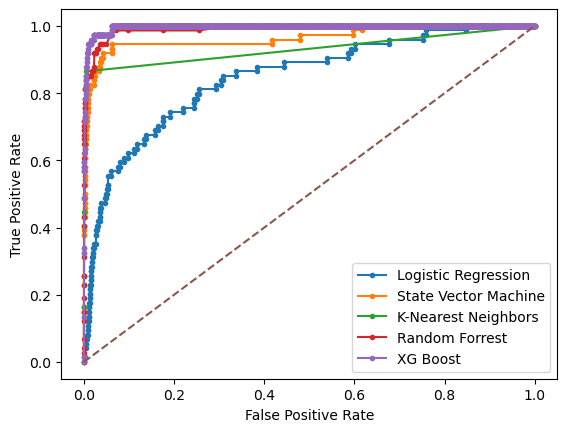

In [263]:
results_no_sample = []
#models = [lr_best_est, svm_best_est, knn_best_est, rf_best_est, xgb_best_est]
models = [lr, svm, knn, rf, xgboost]
for m in models:
    m.fit(X_train, y_train.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = metrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_no_sample.append([acc, rec, auc])

    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(['Logistic Regression', 'State Vector Machine', 'K-Nearest Neighbors', 'Random Forrest', 'XG Boost'])
# show the plot
pyplot.show()

In [ ]:
results_no_sample = []
models = [lr_best_est, svm_best_est, knn_best_est, rf_best_est, xgb_best_est]
#models = [lr, svm, knn, rf, xgb]
for m in models:
    m.fit(X_train, y_train.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = metrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_no_sample.append([acc, rec, auc])

    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(['Logistic Regression', 'State Vector Machine', 'K-Nearest Neighbors', 'Random Forrest', 'XG Boost'])
# show the plot
pyplot.show()

Epoch 1/25
428/428 [==============================] - 3s 4ms/step - loss: 0.1114 - recall: 0.0443 - val_loss: 0.0313 - val_recall: 0.0000e+00
Epoch 2/25
428/428 [==============================] - 1s 3ms/step - loss: 0.0322 - recall: 0.0000e+00 - val_loss: 0.0305 - val_recall: 0.0000e+00
Epoch 3/25
428/428 [==============================] - 1s 3ms/step - loss: 0.0319 - recall: 0.0000e+00 - val_loss: 0.0302 - val_recall: 0.0000e+00
Epoch 4/25
428/428 [==============================] - 1s 3ms/step - loss: 0.0317 - recall: 0.0000e+00 - val_loss: 0.0300 - val_recall: 0.0000e+00
Epoch 5/25
428/428 [==============================] - 2s 4ms/step - loss: 0.0308 - recall: 0.0000e+00 - val_loss: 0.0287 - val_recall: 0.0000e+00
Epoch 6/25
428/428 [==============================] - 1s 3ms/step - loss: 0.0303 - recall: 0.0000e+00 - val_loss: 0.0301 - val_recall: 0.0000e+00
Epoch 7/25
428/428 [==============================] - 2s 4ms/step - loss: 0.0291 - recall: 0.0000e+00 - val_loss: 0.0314 - val_r

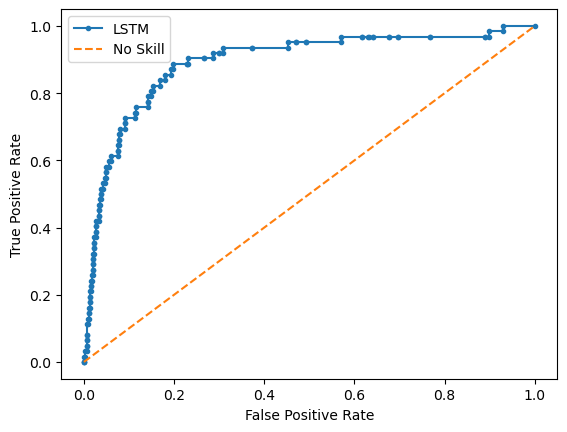

LSTM:
 [[11665     0]
 [   62     0]] 

[[0.9946277820414429, 0.0, 0.49995713673381914], [0.9913873966061226, 0.20967741935483872, 0.6026098198360135], [0.9963332480600324, 0.46774193548387094, 0.7334423350801267], [0.9962479747591029, 0.3387096774193548, 0.6692262489111348], [0.996077428157244, 0.4032258064516129, 0.7012271338301785], [0.9952247, 0.4032258, 0.8404313], [0.9948836, 0.12903225, 0.8423917], [0.9946278, 0.0, 0.8098502], [0.9947983, 0.06451613, 0.86025673], [0.99471307, 0.0, 0.8415173], [0.99471307, 0.0, 0.86598665]]


In [193]:
X_numpy = np.expand_dims(X_train.values[:,:],axis = 2)
y_numpy = y_train.values[:]
X_numpy_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=16, return_sequences=False, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['Recall'])
model.fit(X_numpy, y_numpy, epochs=25, batch_size=64, validation_data=(X_numpy_test, y_numpy_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_no_sample.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_no_sample)

In [195]:
estimator = KerasRegressor(model=model, epochs=100, batch_size=65, verbose=0)
kfold = KFold(n_splits=10)


In [196]:
results = cross_val_score(estimator, X_numpy, y_numpy, cv=kfold, scoring='recall')


INFO:tensorflow:Assets written to: ram://ba7e2351137c40eebb15de6fff39b41d/assets


INFO:tensorflow:Assets written to: ram://ba7e2351137c40eebb15de6fff39b41d/assets
2023-07-16 13:29:58.656626: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a45aeb4f1f8d4c3fb98834527cc2b1f6: INVALID_ARGUMENT: ram://a45aeb4f1f8d4c3fb98834527cc2b1f6 is a directory.


AttributeError: 'Adam' object has no attribute 'build'

In [ ]:

print(results, results.mean(), results.std())

In [178]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [143]:
shap.initjs()

Exact explainer: 11728it [01:17, 132.67it/s]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


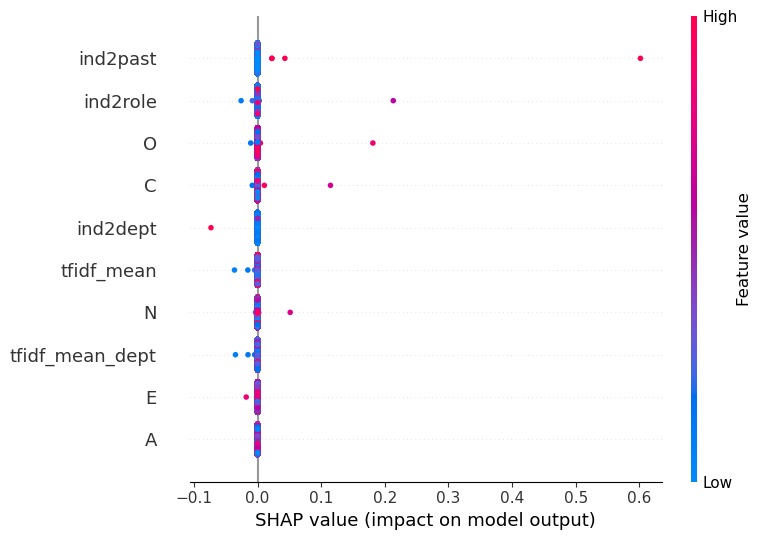

In [144]:
explainer = shap.Explainer(lr_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

Exact explainer: 11728it [2:19:13,  1.40it/s]                            
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


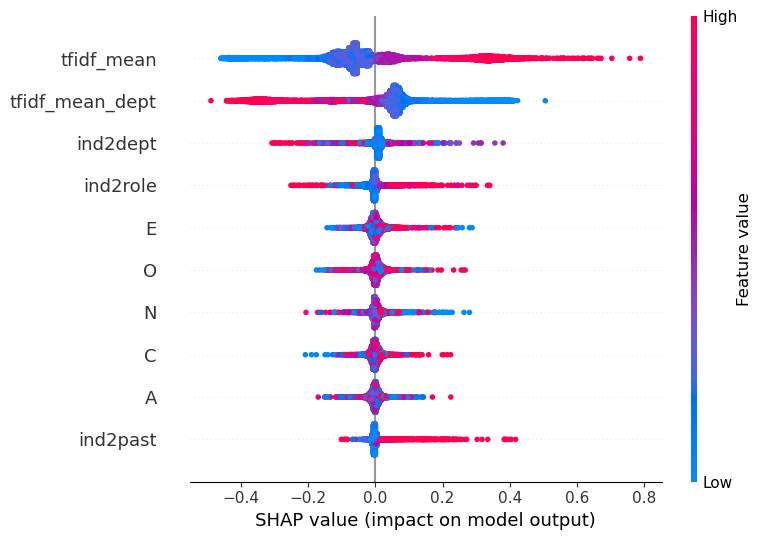

In [158]:
explainer = shap.Explainer(svm_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [ ]:
explainer = shap.Explainer(knn_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

Exact explainer: 11728it [30:43,  6.33it/s]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


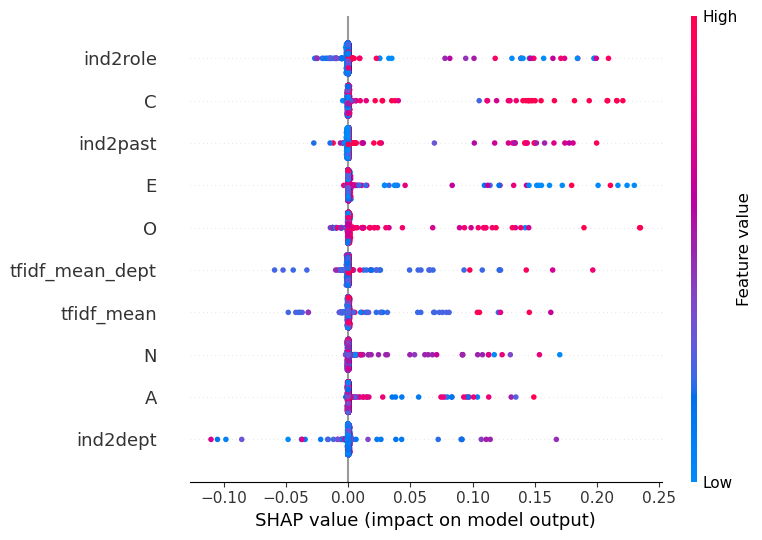

In [160]:
explainer = shap.Explainer(rf_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

Exact explainer: 11728it [08:23, 22.83it/s]                           


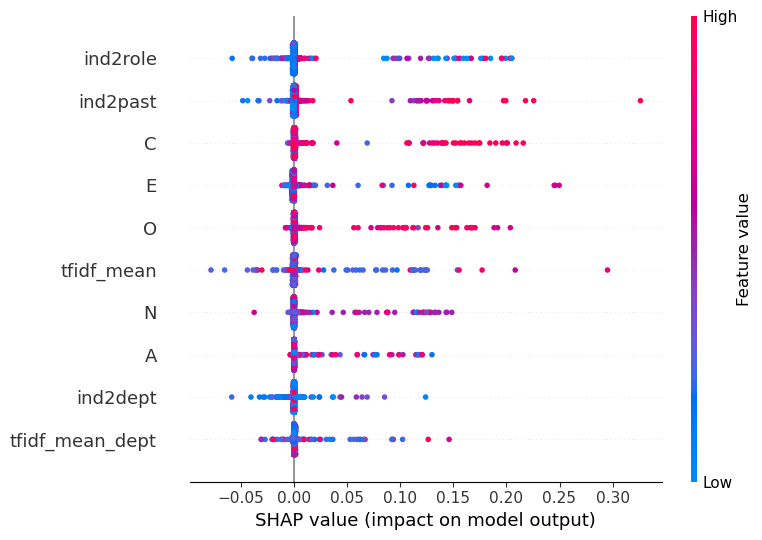

In [145]:
explainer = shap.Explainer(xgb_best_est.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test)

In [161]:
lr_rec_score = cross_val_score(lr_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
svm_rec_score = cross_val_score(svm_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
knn_rec_score = cross_val_score(knn_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
rf_rec_score = cross_val_score(rf_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")
xgb_rec_score = cross_val_score(xgb_best_est, X_train, y_train.values.ravel(), cv=10, scoring="recall")


In [162]:
lr_auc_score = cross_val_score(lr_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
svm_auc_score = cross_val_score(svm_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
knn_auc_score = cross_val_score(knn_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
rf_auc_score = cross_val_score(rf_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")
xgb_auc_score = cross_val_score(xgb_best_est, X_train, y_train.values.ravel(), cv=10, scoring="roc_auc")


In [163]:
lr_f1_score = cross_val_score(lr_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
svm_f1_score = cross_val_score(svm_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
knn_f1_score = cross_val_score(knn_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
rf_f1_score = cross_val_score(rf_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")
xgb_f1_score = cross_val_score(xgb_best_est, X_train, y_train.values.ravel(), cv=10, scoring="f1")

In [164]:
f_oneway(lr_rec_score, svm_rec_score, knn_rec_score, rf_rec_score, xgb_rec_score)
tukey_res = tukey_hsd(lr_rec_score, svm_rec_score, knn_rec_score, rf_rec_score, xgb_rec_score)
print(tukey_res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.393     0.000    -0.528    -0.257
 (0 - 2)     -0.627     0.000    -0.763    -0.492
 (0 - 3)     -0.489     0.000    -0.624    -0.353
 (0 - 4)     -0.597     0.000    -0.733    -0.462
 (1 - 0)      0.393     0.000     0.257     0.528
 (1 - 2)     -0.234     0.000    -0.370    -0.099
 (1 - 3)     -0.096     0.278    -0.231     0.040
 (1 - 4)     -0.204     0.001    -0.340    -0.069
 (2 - 0)      0.627     0.000     0.492     0.763
 (2 - 1)      0.234     0.000     0.099     0.370
 (2 - 3)      0.138     0.043     0.003     0.274
 (2 - 4)      0.030     0.970    -0.105     0.165
 (3 - 0)      0.489     0.000     0.353     0.624
 (3 - 1)      0.096     0.278    -0.040     0.231
 (3 - 2)     -0.138     0.043    -0.274    -0.003
 (3 - 4)     -0.108     0.173    -0.244     0.027
 (4 - 0)      0.597     0.000     0.462     0.733
 (4 - 1)      0.204     0.001   

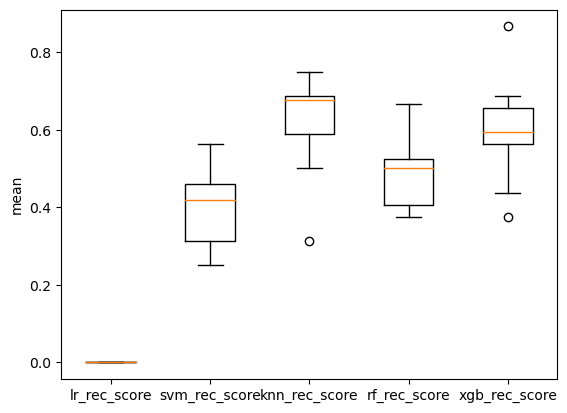

In [165]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lr_rec_score, svm_rec_score, knn_rec_score, rf_rec_score, xgb_rec_score])
ax.set_xticklabels(["lr_rec_score", "svm_rec_score", "knn_rec_score", "rf_rec_score", "xgb_rec_score"]) 
ax.set_ylabel("mean") 
plt.show()

In [166]:
f_oneway(lr_auc_score, svm_auc_score, knn_auc_score, rf_auc_score, xgb_auc_score)
tukey_auc = tukey_hsd(lr_auc_score, svm_auc_score, knn_auc_score, rf_auc_score, xgb_auc_score)
print(tukey_auc)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.065     0.000    -0.106    -0.024
 (0 - 2)     -0.128     0.000    -0.169    -0.087
 (0 - 3)     -0.156     0.000    -0.198    -0.115
 (0 - 4)     -0.173     0.000    -0.214    -0.132
 (1 - 0)      0.065     0.000     0.024     0.106
 (1 - 2)     -0.063     0.001    -0.105    -0.022
 (1 - 3)     -0.091     0.000    -0.133    -0.050
 (1 - 4)     -0.108     0.000    -0.150    -0.067
 (2 - 0)      0.128     0.000     0.087     0.169
 (2 - 1)      0.063     0.001     0.022     0.105
 (2 - 3)     -0.028     0.315    -0.069     0.013
 (2 - 4)     -0.045     0.027    -0.086    -0.004
 (3 - 0)      0.156     0.000     0.115     0.198
 (3 - 1)      0.091     0.000     0.050     0.133
 (3 - 2)      0.028     0.315    -0.013     0.069
 (3 - 4)     -0.017     0.773    -0.058     0.024
 (4 - 0)      0.173     0.000     0.132     0.214
 (4 - 1)      0.108     0.000   

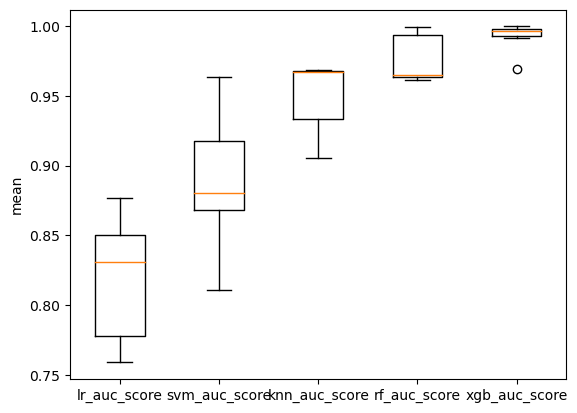

In [167]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lr_auc_score, svm_auc_score, knn_auc_score, rf_auc_score, xgb_auc_score])
ax.set_xticklabels(["lr_auc_score", "svm_auc_score", "knn_auc_score", "rf_auc_score", "xgb_auc_score"]) 
ax.set_ylabel("mean") 
plt.show()

In [168]:
f_oneway(lr_f1_score, svm_f1_score, knn_f1_score, rf_f1_score, xgb_f1_score)
tukey_f1 = tukey_hsd(lr_f1_score, svm_f1_score, knn_f1_score, rf_f1_score, xgb_f1_score)
print(tukey_f1)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.479     0.000    -0.589    -0.370
 (0 - 2)     -0.707     0.000    -0.816    -0.598
 (0 - 3)     -0.602     0.000    -0.711    -0.492
 (0 - 4)     -0.714     0.000    -0.824    -0.605
 (1 - 0)      0.479     0.000     0.370     0.589
 (1 - 2)     -0.228     0.000    -0.337    -0.118
 (1 - 3)     -0.122     0.021    -0.232    -0.013
 (1 - 4)     -0.235     0.000    -0.344    -0.126
 (2 - 0)      0.707     0.000     0.598     0.816
 (2 - 1)      0.228     0.000     0.118     0.337
 (2 - 3)      0.105     0.064    -0.004     0.215
 (2 - 4)     -0.007     1.000    -0.117     0.102
 (3 - 0)      0.602     0.000     0.492     0.711
 (3 - 1)      0.122     0.021     0.013     0.232
 (3 - 2)     -0.105     0.064    -0.215     0.004
 (3 - 4)     -0.113     0.040    -0.222    -0.003
 (4 - 0)      0.714     0.000     0.605     0.824
 (4 - 1)      0.235     0.000   

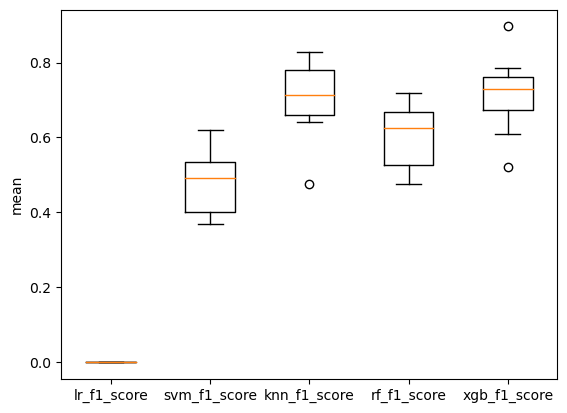

In [169]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.boxplot([lr_f1_score, svm_f1_score, knn_f1_score, rf_f1_score, xgb_f1_score])
ax.set_xticklabels(["lr_f1_score", "svm_f1_score", "knn_f1_score", "rf_f1_score", "xgb_f1_score"]) 
ax.set_ylabel("mean") 
plt.show()

# CREATE SAMPLED AND AUGMENTED DATA

In [82]:
final_undersample = RandomUnderSampler(sampling_strategy='majority')
X_final_under, y_final_under = final_undersample.fit_resample(X_train, y_train)
final_under = X_final_under.copy()
final_under['label'] = y_final_under

final_oversample = RandomOverSampler(sampling_strategy='minority')
X_final_over, y_final_over = final_oversample.fit_resample(X_train, y_train)
final_over = X_final_over.copy()
final_over['label'] = y_final_over

final_smote = SMOTE(k_neighbors=5)
X_final_smote, y_final_smote = final_smote.fit_resample(X_train, y_train)
final_smote = X_final_smote.copy()
final_smote['label'] = y_final_smote

final_blsmote = BorderlineSMOTE(k_neighbors=5)
X_final_blsmote, y_final_blsmote = final_blsmote.fit_resample(X_train, y_train)
final_blsmote = X_final_blsmote.copy()
final_blsmote['label'] = y_final_blsmote

final_adasyn = ADASYN(n_neighbors=5)
X_final_adasyn, y_final_adasyn = final_adasyn.fit_resample(X_train, y_train)
final_adasyn = X_final_adasyn.copy()
final_adasyn['label'] = y_final_adasyn

# Undersampling

LogisticRegression(max_iter=10000) 
 [[10045  1620]
 [   10    52]] 

SVC(probability=True) 
 [[10269  1396]
 [    7    55]] 

KNeighborsClassifier(n_neighbors=4) 
 [[9972 1693]
 [   4   58]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[9545 2120]
 [   4   58]] 

AdaBoostClassifier() 
 [[10041  1624]
 [    4    58]] 



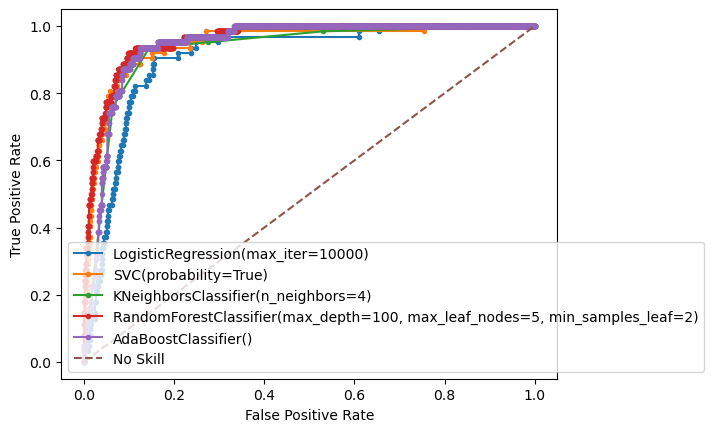

In [84]:
results_under = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_final_under, y_final_under.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_under.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


Epoch 1/25
20/20 [==============================] - 5s 90ms/step - loss: 0.6799 - recall: 0.7595 - val_loss: 0.6857 - val_recall: 0.8226
Epoch 2/25
20/20 [==============================] - 1s 59ms/step - loss: 0.6393 - recall: 0.8291 - val_loss: 0.6725 - val_recall: 0.8226
Epoch 3/25
20/20 [==============================] - 1s 60ms/step - loss: 0.5708 - recall: 0.7785 - val_loss: 0.5244 - val_recall: 0.7258
Epoch 4/25
20/20 [==============================] - 1s 58ms/step - loss: 0.5290 - recall: 0.7405 - val_loss: 0.4798 - val_recall: 0.7097
Epoch 5/25
20/20 [==============================] - 1s 60ms/step - loss: 0.5127 - recall: 0.7468 - val_loss: 0.4725 - val_recall: 0.7258
Epoch 6/25
20/20 [==============================] - 1s 58ms/step - loss: 0.5063 - recall: 0.7468 - val_loss: 0.4439 - val_recall: 0.6935
Epoch 7/25
20/20 [==============================] - 1s 60ms/step - loss: 0.4917 - recall: 0.7405 - val_loss: 0.4052 - val_recall: 0.6452
Epoch 8/25
20/20 [=======================

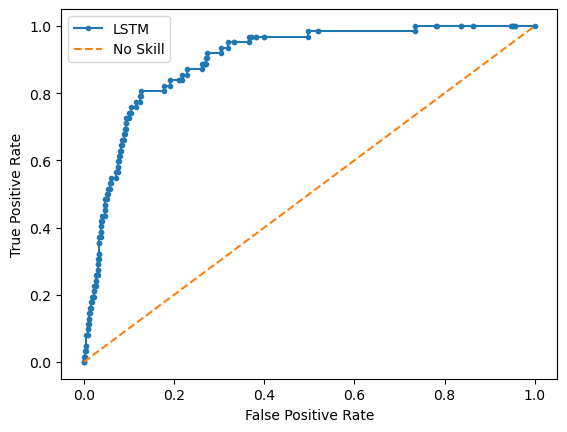

LSTM:
 [[10089  1576]
 [   12    50]] 

[[0.8610045194849493, 0.8387096774193549, 0.849916347496647], [0.880361558795941, 0.8870967741935484, 0.8837112675082616], [0.8552912083226741, 0.9354838709677419, 0.8951744258396361], [0.8188795088257866, 0.9354838709677419, 0.876871811180399], [0.8611750660868083, 0.9354838709677419, 0.898131991206117], [0.864586, 0.8064516, 0.8992934]]


In [86]:
X_numpy_under = np.expand_dims(X_final_under.values[:,:],axis = 2)
y_numpy_under = y_final_under.values[:]
X_numpy_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_under_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(len(X_final_under.columns), 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['Recall'])
model.fit(X_numpy_under, y_numpy_under, epochs=25, batch_size=16, validation_data=(X_numpy_under_test, y_numpy_under_test))
ypred = model.predict(X_numpy_under_test).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy_under_test, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy_under_test, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy_under_test, ypred)
auc = bauc.result().numpy()

results_under.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy_under_test, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_under)

# Oversampling

LogisticRegression(max_iter=10000) 
 [[8641 1037]
 [   6   39]] 

KNeighborsClassifier(n_neighbors=10) 
 [[9606   72]
 [  19   26]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[8154 1524]
 [   4   41]] 

AdaBoostClassifier() 
 [[8872  806]
 [   4   41]] 



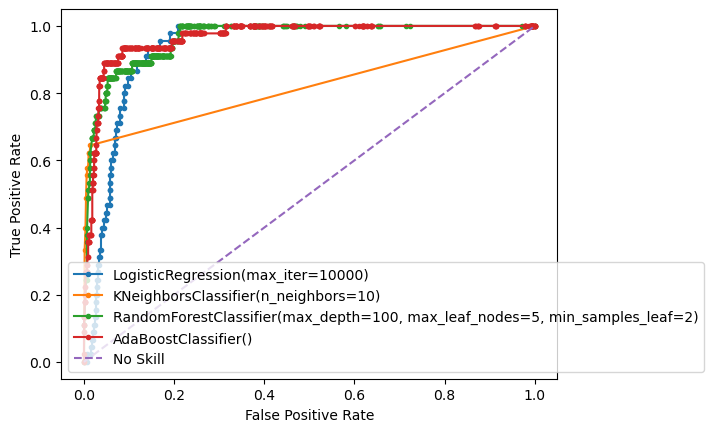

In [185]:
results_over = []
models = [lr, knn, rf, ada]
for m in models:
    m.fit(X_final_over, y_final_over.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_over.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Epoch 1/25
1211/1211 [==============================] - 16s 11ms/step - loss: 0.3595 - accuracy: 0.8574 - val_loss: 0.3287 - val_accuracy: 0.8818
Epoch 2/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.2634 - accuracy: 0.9109 - val_loss: 0.2044 - val_accuracy: 0.9268
Epoch 3/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.2203 - accuracy: 0.9293 - val_loss: 0.2368 - val_accuracy: 0.9137
Epoch 4/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.1716 - accuracy: 0.9409 - val_loss: 0.1896 - val_accuracy: 0.9247
Epoch 5/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.1237 - accuracy: 0.9579 - val_loss: 0.1204 - val_accuracy: 0.9512
Epoch 6/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.0970 - accuracy: 0.9695 - val_loss: 0.1285 - val_accuracy: 0.9538
Epoch 7/25
1211/1211 [==============================] - 13s 11ms/step - loss: 0.0819 - accuracy: 0.9746 - val_loss: 0.0972 -

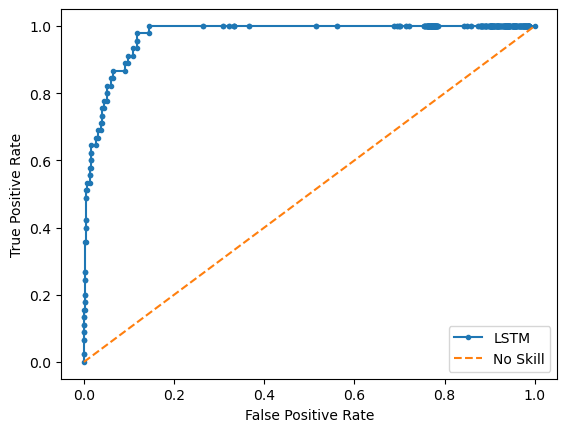

LSTM:
 [[9549  129]
 [  20   25]] 

[[0.8927285817134629, 0.8666666666666667, 0.8797582145071295], [0.9906407487401008, 0.5777777777777777, 0.7851691120754977], [0.8428468579656485, 0.9111111111111111, 0.8768202796721085], [0.9166923788954027, 0.9111111111111111, 0.9139147206723152], [0.9846755, 0.5555556, 0.8754082]]


In [186]:
X_numpy_over = np.expand_dims(X_final_over.values[:,:],axis = 2)
y_numpy_over = y_final_over.values[:]
X_numpy_over_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_over_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_over.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_over, y_numpy_over, epochs=25, batch_size=64, validation_data=(X_numpy_over_test, y_numpy_over_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_over.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_over)

# Hybrid

In [93]:
final_oversample_1 = RandomOverSampler(sampling_strategy=0.3)
X_final_over_1, y_final_over_1 = final_oversample_1.fit_resample(X_train, y_train)
X_final_ou, y_final_ou = final_undersample.fit_resample(X_final_over_1, y_final_over_1)

In [94]:
print("Number of malicious records: ", y_final_ou.value_counts()[1])
print("Number of normal records: ", y_final_ou.value_counts()[0])

Number of malicious records:  10073
Number of normal records:  10073


LogisticRegression(max_iter=10000) 
 [[20439  1969]
 [   16    77]] 

SVC(probability=True) 
 [[21188  1220]
 [   12    81]] 

KNeighborsClassifier(n_neighbors=10) 
 [[21906   502]
 [   25    68]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[19121  3287]
 [    6    87]] 

AdaBoostClassifier() 
 [[21264  1144]
 [    7    86]] 



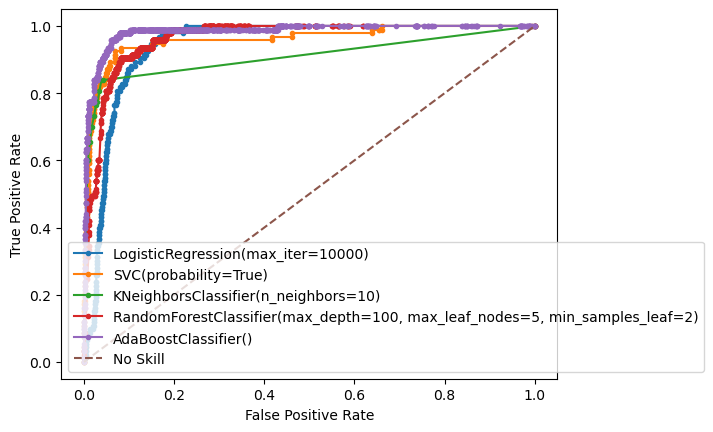

In [95]:
results_ou = []
models = [lr, svm, knn, rf, ada]
for m in models:
    m.fit(X_final_ou, y_final_ou.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    #prec = skmetrics.precision_score(y_test, predicted)
    #f1 = skmetrics.f1_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_ou.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

Epoch 1/25
315/315 [==============================] - 8s 16ms/step - loss: 0.4131 - accuracy: 0.8222 - val_loss: 0.3080 - val_accuracy: 0.8396
Epoch 2/25
315/315 [==============================] - 5s 15ms/step - loss: 0.2729 - accuracy: 0.8892 - val_loss: 0.2510 - val_accuracy: 0.8845
Epoch 3/25
315/315 [==============================] - 5s 14ms/step - loss: 0.2244 - accuracy: 0.9076 - val_loss: 0.2251 - val_accuracy: 0.8862
Epoch 4/25
315/315 [==============================] - 5s 14ms/step - loss: 0.1879 - accuracy: 0.9227 - val_loss: 0.2113 - val_accuracy: 0.8987
Epoch 5/25
315/315 [==============================] - 4s 14ms/step - loss: 0.1620 - accuracy: 0.9362 - val_loss: 0.1806 - val_accuracy: 0.9120
Epoch 6/25
315/315 [==============================] - 4s 14ms/step - loss: 0.1375 - accuracy: 0.9502 - val_loss: 0.1174 - val_accuracy: 0.9470
Epoch 7/25
315/315 [==============================] - 4s 14ms/step - loss: 0.1167 - accuracy: 0.9589 - val_loss: 0.1244 - val_accuracy: 0.9439

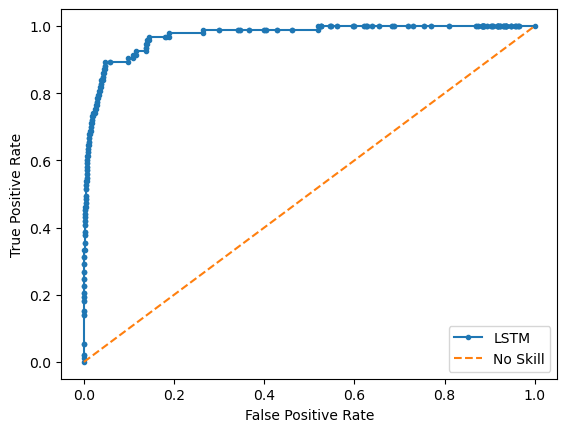

LSTM:
 [[22068   340]
 [   28    65]] 

[[0.9117816985911738, 0.8279569892473119, 0.8700432929099823], [0.945246877916537, 0.8709677419354839, 0.9082614504036577], [0.9765788187191681, 0.7311827956989247, 0.854390041191126], [0.8536509488467179, 0.9354838709677419, 0.8943975941771948], [0.9488467179236478, 0.9247311827956989, 0.9368389937541508], [0.9836452, 0.6989247, 0.9343517]]


In [96]:
X_numpy_ou = np.expand_dims(X_final_ou.values[:,:],axis = 2)
y_numpy_ou = y_final_ou.values[:]
X_numpy_ou_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_ou_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_over.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_ou, y_numpy_ou, epochs=25, batch_size=64, validation_data=(X_numpy_ou_test, y_numpy_ou_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_ou.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_ou)

# SMOTE

LogisticRegression(max_iter=10000) 
 [[20525  1883]
 [   16    77]] 

KNeighborsClassifier(n_neighbors=10) 
 [[22152   256]
 [   28    65]] 

RandomForestClassifier(max_depth=100, max_leaf_nodes=5, min_samples_leaf=2) 
 [[  814 21594]
 [    1    92]] 

AdaBoostClassifier() 
 [[18236  4172]
 [    3    90]] 



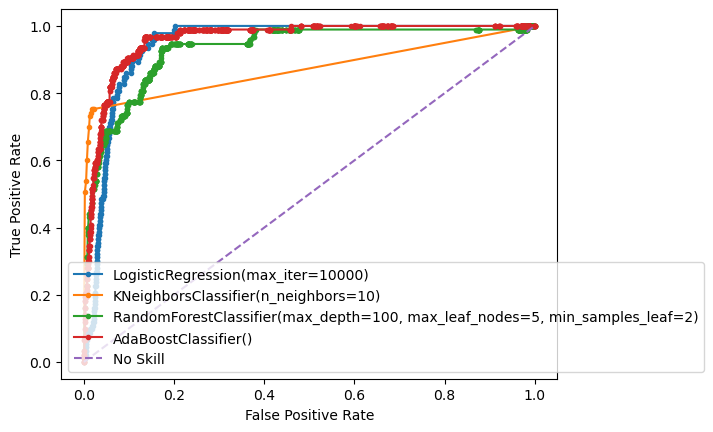

In [97]:
results_smote = []
models = [lr, knn, rf, ada]

for m in models:
    m.fit(X_final_smote, y_final_smote.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = skmetrics.recall_score(y_test, predicted)
    auc = skmetrics.roc_auc_score(y_test, predicted)
    print(m, "\n", skmetrics.confusion_matrix(y_test,predicted), "\n")
    results_smote.append([acc, rec, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Epoch 1/25
315/315 [==============================] - 8s 17ms/step - loss: 0.3862 - accuracy: 0.8413 - val_loss: 0.3170 - val_accuracy: 0.8408
Epoch 2/25
315/315 [==============================] - 4s 14ms/step - loss: 0.2670 - accuracy: 0.8916 - val_loss: 0.2674 - val_accuracy: 0.8791
Epoch 3/25
315/315 [==============================] - 5s 14ms/step - loss: 0.2188 - accuracy: 0.9099 - val_loss: 0.2318 - val_accuracy: 0.8851
Epoch 4/25
315/315 [==============================] - 4s 14ms/step - loss: 0.1794 - accuracy: 0.9266 - val_loss: 0.1610 - val_accuracy: 0.9270
Epoch 5/25
315/315 [==============================] - 5s 15ms/step - loss: 0.1471 - accuracy: 0.9437 - val_loss: 0.1563 - val_accuracy: 0.9279
Epoch 6/25
315/315 [==============================] - 5s 14ms/step - loss: 0.1259 - accuracy: 0.9552 - val_loss: 0.1135 - val_accuracy: 0.9506
Epoch 7/25
315/315 [==============================] - 5s 15ms/step - loss: 0.1042 - accuracy: 0.9645 - val_loss: 0.1039 - val_accuracy: 0.9590

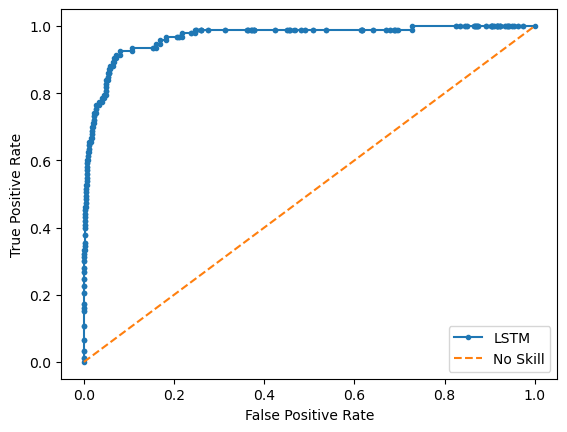

LSTM:
 [[22017   391]
 [   31    62]] 

[[0.9117816985911738, 0.8279569892473119, 0.8700432929099823], [0.945246877916537, 0.8709677419354839, 0.9082614504036577], [0.9765788187191681, 0.7311827956989247, 0.854390041191126], [0.8536509488467179, 0.9354838709677419, 0.8943975941771948], [0.9488467179236478, 0.9247311827956989, 0.9368389937541508], [0.9836452, 0.6989247, 0.9343517]]


In [98]:
X_numpy_smote = np.expand_dims(X_final_smote.values[:,:],axis = 2)
y_numpy_smote = y_final_smote.values[:]
X_numpy_smote_test = np.expand_dims(X_test.values[:,:],axis = 2)
y_numpy_smote_test = y_test.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_smote.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_ou, y_numpy_ou, epochs=25, batch_size=64, validation_data=(X_numpy_ou_test, y_numpy_ou_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_smote.append([acc, rec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
predlabels = [int(p>=0.5) for p in ypred]
print("LSTM:\n", skmetrics.confusion_matrix(y_test,predlabels), "\n")
print(results_ou)

# ADASYN

In [79]:
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_final_adasyn, y_final_adasyn, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# ada_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# ada_svm_best_est = grid.best_estimator_



In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn,y_train_adasyn.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# ada_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# ada_rf_best_est = grid.best_estimator_


In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_adasyn, y_train_adasyn.values.ravel())
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# ada_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = ada_lr_best_est
# svm = ada_svm_best_est
# knn = ada_knn_best_est
# rf = ada_rf_best_est
# ada = ada_ada_best_est


In [80]:
results_adasyn = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_adasyn, y_train_adasyn.values.ravel())
    predicted = m.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_adasyn.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_adasyn = np.expand_dims(X_train_adasyn.values[:,:],axis = 2)
y_numpy_adasyn = y_train_adasyn.values[:]
X_numpy_adasyn_test = np.expand_dims(X_test_adasyn.values[:,:],axis = 2)
y_numpy_adasyn_test = y_test_adasyn.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_adasyn.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_adasyn)

AttributeError: module 'keras.metrics.metrics' has no attribute 'accuracy_score'

# Borderline SMOTE

In [ ]:
X_train_blsmote, X_test_blsmote, y_train_blsmote, y_test_blsmote = train_test_split(X_final_blsmote, y_final_blsmote, test_size=0.3)

In [ ]:
# #C is the most meaningful - penalty had no impact and would error out
# param_grid = {'C': [0.1,1, 10, 100], 'max_iter': [1000]}
# grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=0,cv=10,scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("logistic regression best: ", grid.best_estimator_)
# bls_lr_best_est = grid.best_estimator_



In [ ]:

# #linear failed to converge
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0, cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("SVM best: ", grid.best_estimator_)
# bls_svm_best_est = grid.best_estimator_

In [ ]:

# param_grid = {'n_neighbors': list(range(1,21)), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance'] }
# grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote,y_train_blsmote.values.ravel())
# print("KNN best: ", grid.best_estimator_)
# bls_knn_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [3, 5, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid = GridSearchCV(RandomForestClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote.values.ravel())
# print("RF Best estimater:", grid.best_estimator_)
# print("RF Best parameters:", grid.best_params_)
# print("RF Best score:", grid.best_score_)
# bls_rf_best_est = grid.best_estimator_



In [ ]:

# param_grid = {
#      'n_estimators': [100, 200, 300],
#      'learning_rate': [0.01, 0.05, 0.1, 1],
#  }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
# grid.fit(X_train_blsmote, y_train_blsmote)
# print("ADA Best estimater:", grid.best_estimator_)
# print("ADA Best parameters:", grid.best_params_)
# print("ADA Best score:", grid.best_score_)
# bls_ada_best_est = grid.best_estimator_

In [ ]:
# #Adapt from above
# lr = LogisticRegression(max_iter=1000)
# svm = SVC(probability=True)
# knn = bls_knn_best_est
# rf = bls_rf_best_est
# ada = bls_ada_best_est

In [ ]:
results_blsmote = []
models = [lr, svm, knn, rf, ada]

for m in models:
    m.fit(X_train_blsmote, y_train_blsmote.values.ravel())
    predicted = m.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    rec = metrics.recall_score(y_test, predicted)
    prec = metrics.precision_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    results_blsmote.append([acc, rec, prec, f1, auc])
    m_probs = m.predict_proba(X_test)
    m_probs = m_probs[:, 1]
    m_fpr, m_tpr, _ = roc_curve(y_test, m_probs)
    pyplot.plot(m_fpr, m_tpr, marker='.', label=(m))

X_numpy_blsmote = np.expand_dims(X_train_blsmote.values[:,:],axis = 2)
y_numpy_blsmote = y_train_blsmote.values[:]
X_numpy_blsmote_test = np.expand_dims(X_test_blsmote.values[:,:],axis = 2)
y_numpy_blsmote_test = y_test_blsmote.values[:]
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_train.columns), 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_numpy_smote, y_numpy_smote, epochs=15, batch_size=64, validation_data=(X_numpy_smote_test, y_numpy_smote_test))

X_numpy = np.expand_dims(X_test.values[:],axis = 2)
y_numpy = y_test.values[:]
ypred = model.predict(X_numpy).ravel()

ba = tf.keras.metrics.BinaryAccuracy()
ba.update_state(y_numpy, ypred)
acc = ba.result().numpy()

br = tf.keras.metrics.Recall()
br.update_state(y_numpy, ypred)
rec = br.result().numpy()

bp = tf.keras.metrics.Precision()
bp.update_state(y_numpy, ypred)
prec = bp.result().numpy()

# bf1 = tf.keras.metrics.F1Score()
# bf1.update_state(y_numpy, ypred)
# f1 = bf1.result().numpy()

bauc = tf.keras.metrics.AUC()
bauc.update_state(y_numpy, ypred)
auc = bauc.result().numpy()

results_blsmote.append([acc, rec, prec, auc])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_numpy, ypred)
pyplot.plot(fpr_keras, tpr_keras, marker='.', label=("LSTM"))
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(results_blsmote)

In [ ]:
# sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

EXPERIMENT SECTION

In [ ]:
param_grid = {
     'n_estimators': [100, 200, 300],
     'learning_rate': [0.01, 0.05, 0.1, 1],
     'algorithm': ['SAMME', 'SAMME.R']
 }
grid = GridSearchCV(AdaBoostClassifier(), param_grid,refit=True,verbose=0,cv=10, scoring='recall', return_train_score=False)
grid.fit(X_final_under, y_final_under.values.ravel())
print("ADA Best estimater:", grid.best_estimator_)
print("ADA Best parameters:", grid.best_params_)
print("ADA Best score:", grid.best_score_)
ada_ada_best_est = grid.best_estimator_
ada = ada_ada_best_est

results_under = pd.DataFrame(columns=['model', 'acc', 'rec', 'auc'])
for e in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # X_test.drop(columns=[10000], inplace=True)
    # X_train.drop(columns=[10000], inplace=True)

    # X_test.drop(columns=[10000, 10007, 10009, 10011, 10012, 10008, 10010], inplace=True)
    # X_train.drop(columns=[10000, 10007, 10009, 10011, 10012, 10008, 10010], inplace=True)

    # X_test = X_test[[10007, 10009, 10011, 10012, 10008, 10010]]
    # X_train = X_train[[10007, 10009, 10011, 10012, 10008, 10010]]

    # X_test.drop(columns=[10000, 10007, 10009, 10011, 10012], inplace=True)
    # X_train.drop(columns=[10000, 10007, 10009, 10011, 10012], inplace=True)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    final_undersample = RandomUnderSampler(sampling_strategy='majority')
    X_final_under, y_final_under = final_undersample.fit_resample(X_train, y_train)
    final_under = X_final_under.copy()
    final_under['label'] = y_final_under

    final_oversample = RandomOverSampler(sampling_strategy='minority')
    X_final_over, y_final_over = final_oversample.fit_resample(X_train, y_train)
    final_over = X_final_over.copy()
    final_over['label'] = y_final_over

    final_smote = SMOTE(k_neighbors=10)
    X_final_smote, y_final_smote = final_smote.fit_resample(X_train, y_train)
    final_smote = X_final_smote.copy()
    final_smote['label'] = y_final_smote

    final_blsmote = BorderlineSMOTE(k_neighbors=10)
    X_final_blsmote, y_final_blsmote = final_blsmote.fit_resample(X_train, y_train)
    final_blsmote = X_final_blsmote.copy()
    final_blsmote['label'] = y_final_blsmote

    final_adasyn = ADASYN(n_neighbors=10)
    X_final_adasyn, y_final_adasyn = final_adasyn.fit_resample(X_train, y_train)
    final_adasyn = X_final_adasyn.copy()
    final_adasyn['label'] = y_final_adasyn

    models = [lr, knn, rf, ada]
    for m in models:
        m.fit(X_final_under, y_final_under.values.ravel())
        predicted = m.predict(X_test)
        acc = skmetrics.accuracy_score(y_test, predicted)
        rec = skmetrics.recall_score(y_test, predicted)
        auc = skmetrics.roc_auc_score(y_test, predicted)
        results_under.loc[len(results_under.index)] = [m, acc, rec, auc] 


    X_numpy_under = np.expand_dims(X_final_under.values[:,:],axis = 2)
    y_numpy_under = y_final_under.values[:]
    X_numpy_under_test = np.expand_dims(X_test.values[:,:],axis = 2)
    y_numpy_under_test = y_test.values[:]
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(len(X_final_under.columns), 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    model.fit(X_numpy_under, y_numpy_under, epochs=10, batch_size=16, validation_data=(X_numpy_under_test, y_numpy_under_test))
    ypred = model.predict(X_numpy_under_test).ravel()

    ba = tf.keras.metrics.BinaryAccuracy()
    ba.update_state(y_numpy_under_test, ypred)
    acc = ba.result().numpy()

    br = tf.keras.metrics.Recall()
    br.update_state(y_numpy_under_test, ypred)
    rec = br.result().numpy()

    bauc = tf.keras.metrics.AUC()
    bauc.update_state(y_numpy_under_test, ypred)
    auc = bauc.result().numpy()

    results_under.loc[len(results_under.index)] = ['lstm', acc, rec, auc] 
    results_under

results_under.to_excel("/Users/ken.clements/Desktop/results6.xlsx")